In [1]:
from fastai.vision import *
import os

## Loading dataset

In [2]:
path = Path('dataset')
path.ls()

[PosixPath('dataset/models'),
 PosixPath('dataset/best_27.pkl'),
 PosixPath('dataset/test.csv'),
 PosixPath('dataset/Train Images'),
 PosixPath('dataset/export.pkl'),
 PosixPath('dataset/train.csv'),
 PosixPath('dataset/best_27'),
 PosixPath('dataset/Test Images')]

In [3]:
# os.getcwd()
# os.listdir()
path

PosixPath('dataset')

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [5]:
np.random.seed(7) # fixing the split into train & valid

src = (ImageList.from_csv(path, 'train.csv', folder='Train Images')
       .split_by_rand_pct(0.2) # 20% validation data
       .label_from_df()
    )


In [6]:
data = (src.transform(get_transforms(), size=(112,112))
       .databunch()
       .normalize(imagenet_stats))

In [7]:
len(data.train_ds), len(data.valid_ds), data.classes, data.valid_ds[0]

(4787,
 1196,
 ['Attire', 'Decorationandsignage', 'Food', 'misc'],
 (Image (3, 112, 112), Category Attire))

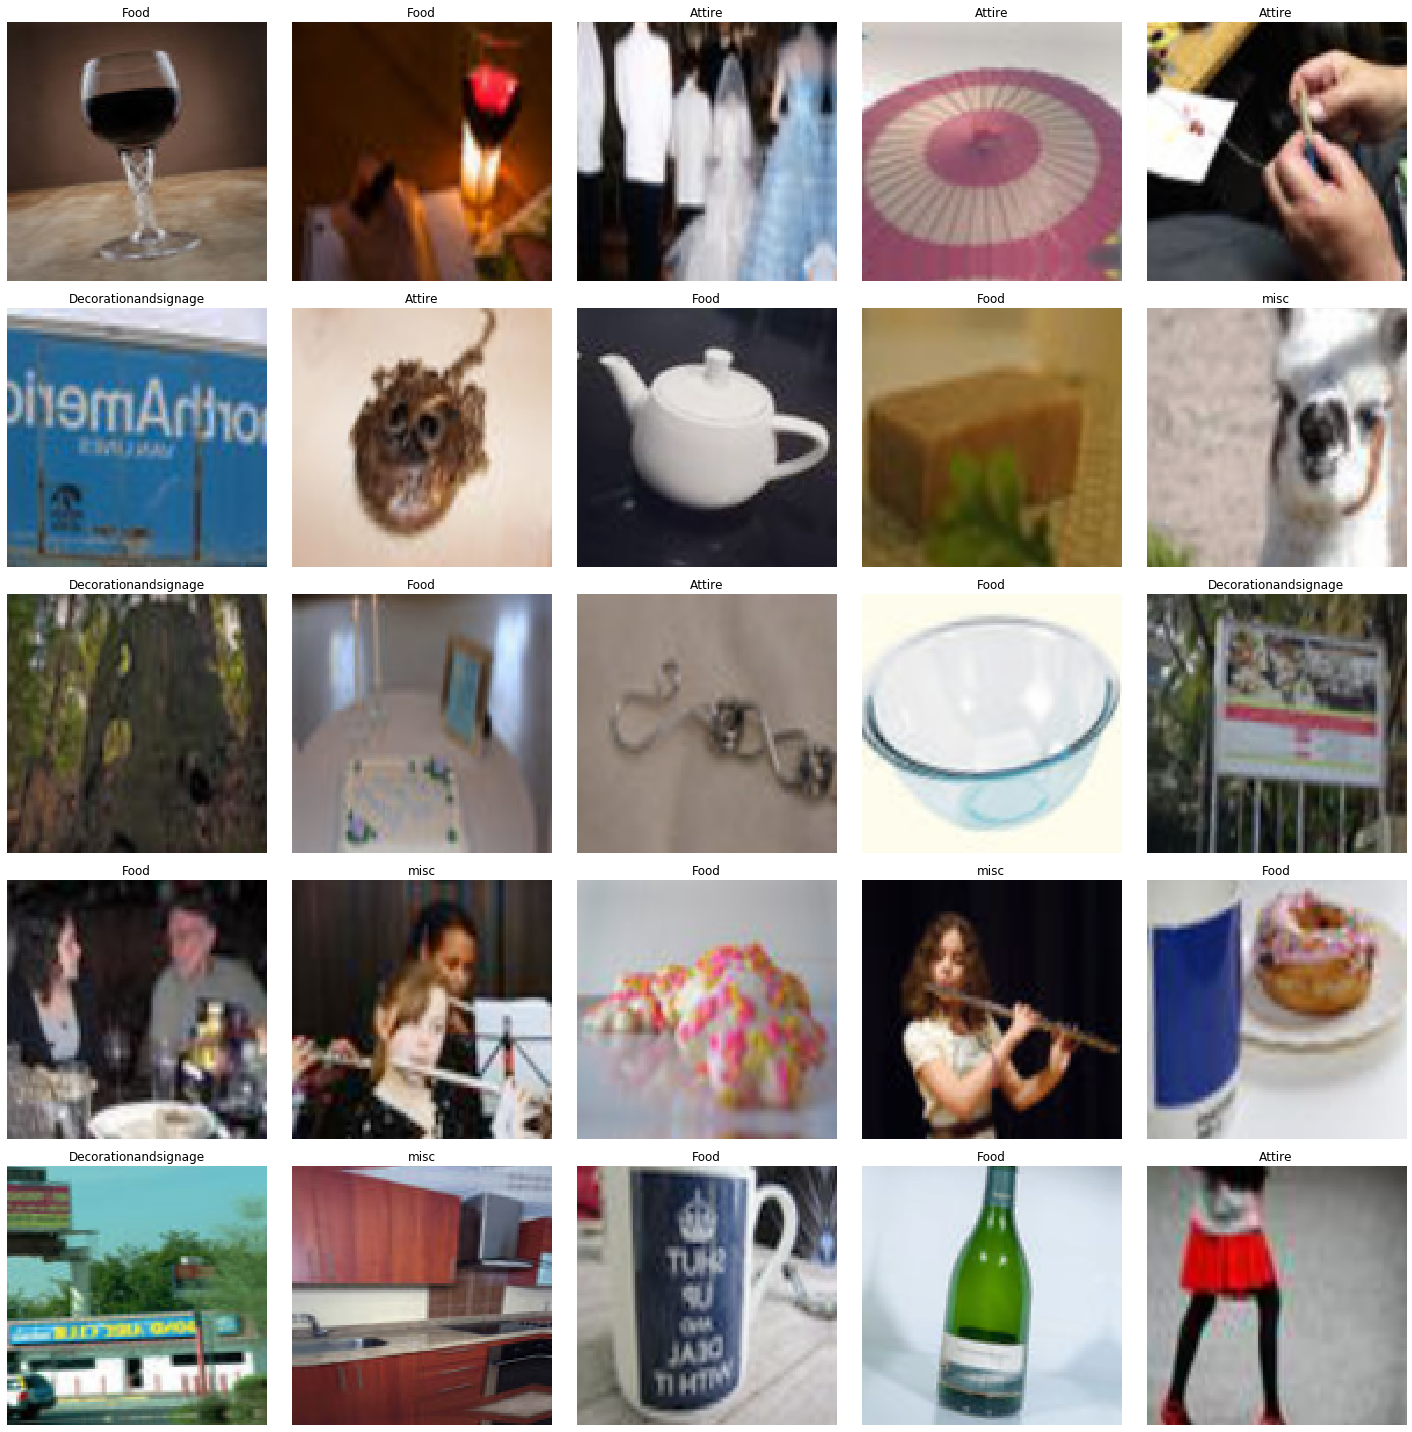

In [8]:
data.show_batch()

## Learner

In [9]:
#f_score = partial(fbeta, beta=1.)
# metrics = [error_rate, f_score]  # performance matrices
learn.load('stage-2-112-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (4787 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
misc,Attire,Food,misc,Food
Path: dataset;

Valid: LabelList (1196 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
Attire,Food,Attire,Attire,misc
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [8]:
learn =  cnn_learner(data, models.resnet50, metrics=accuracy)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


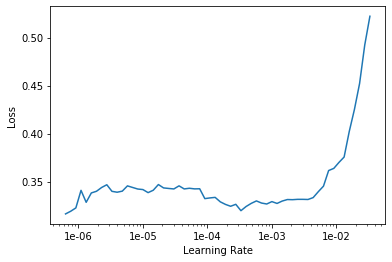

In [13]:
learn.recorder.plot()

In [14]:
lr = 1e-4

In [15]:
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.335856,0.700171,0.804348,00:28
1,0.324379,0.692062,0.806020,00:26
2,0.323869,0.658590,0.810201,00:26
3,0.313009,0.634619,0.808528,00:27
4,0.283915,0.616263,0.813545,00:26
5,0.268240,0.626705,0.816054,00:27
6,0.260632,0.622109,0.816054,00:27
7,0.266300,0.613707,0.808528,00:26
8,0.253559,0.603390,0.820234,00:28
9,0.231138,0.597835,0.816054,00:28


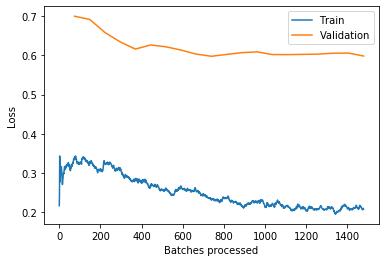

In [16]:
learn.recorder.plot_losses()

In [23]:
# learn.load('stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (4787 items)
x: ImageList
Image (3, 60, 80),Image (3, 60, 80),Image (3, 60, 80),Image (3, 60, 80),Image (3, 60, 80)
y: CategoryList
misc,Attire,Food,misc,Food
Path: dataset;

Valid: LabelList (1196 items)
x: ImageList
Image (3, 60, 80),Image (3, 60, 80),Image (3, 60, 80),Image (3, 60, 80),Image (3, 60, 80)
y: CategoryList
Attire,Food,Attire,Attire,misc
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 

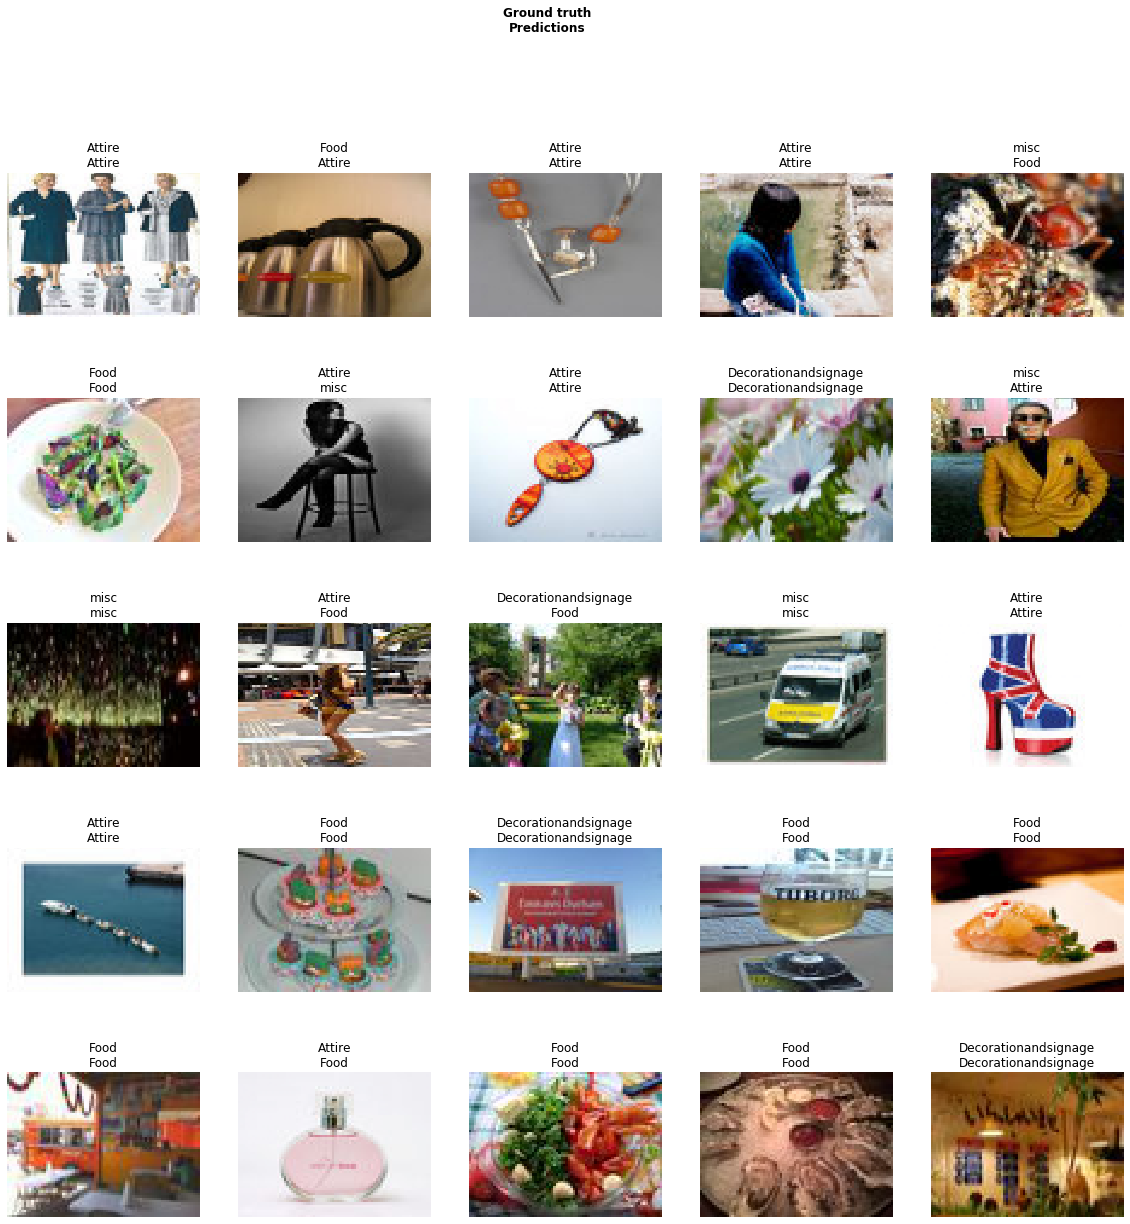

In [11]:
learn.show_results()

In [17]:
learn.save('stage-1-112-rn50')

In [16]:
learn.export()

In [27]:
os.listdir('dataset')

['models',
 'test.csv',
 'Train Images',
 'export.pkl',
 'train.csv',
 'Test Images']

## Results interpretation


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

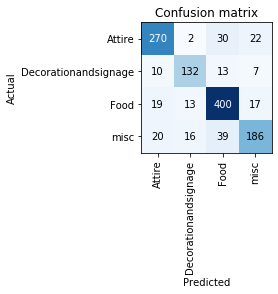

In [11]:
interp.plot_confusion_matrix()

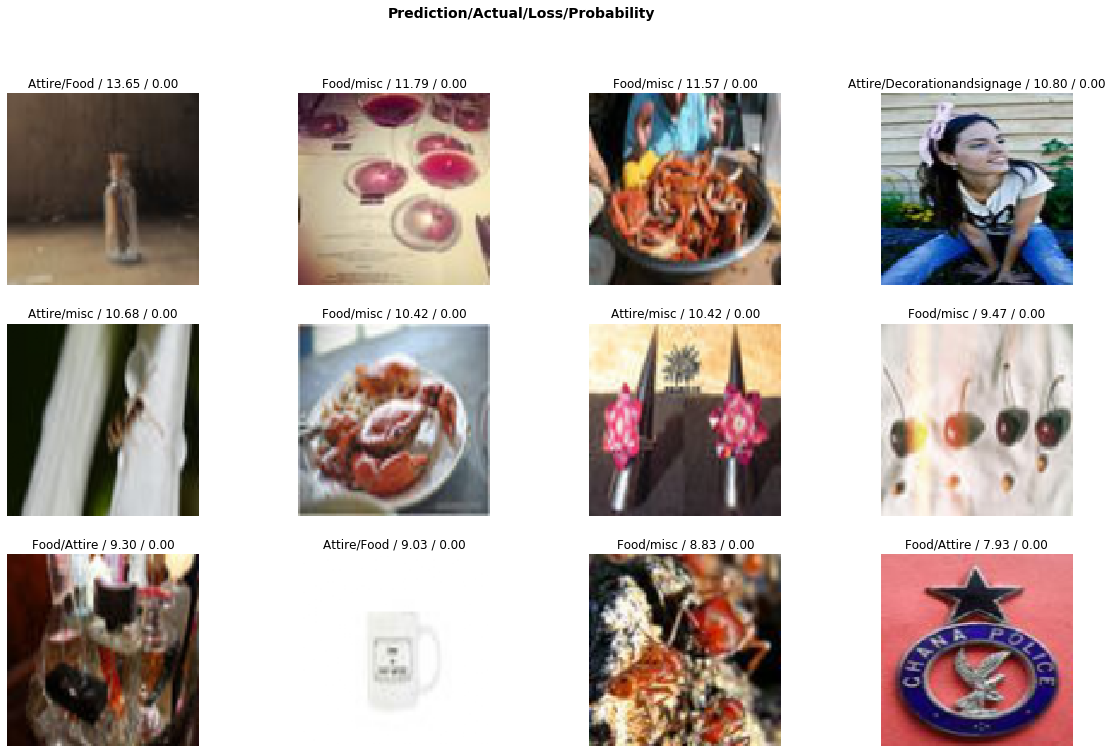

In [12]:
interp.plot_top_losses(12, figsize=(20,12))

In [13]:
interp.most_confused(12)

[('misc', 'Food', 39),
 ('Attire', 'Food', 30),
 ('Attire', 'misc', 22),
 ('misc', 'Attire', 20),
 ('Food', 'Attire', 19),
 ('Food', 'misc', 17),
 ('misc', 'Decorationandsignage', 16),
 ('Decorationandsignage', 'Food', 13),
 ('Food', 'Decorationandsignage', 13)]

## Fine-tunning

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


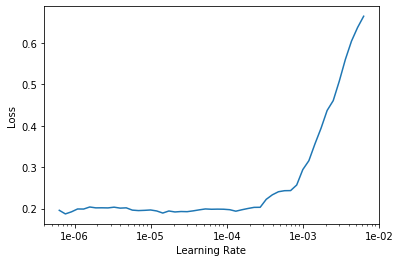

In [24]:
learn.recorder.plot()

In [25]:
new_lr = slice(1e-5,lr/5)

In [26]:
learn.fit_one_cycle(20, new_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.211247,0.607716,0.818562,00:36
1,0.200494,0.604385,0.821070,00:35
2,0.197544,0.604075,0.817726,00:34
3,0.191421,0.604421,0.812709,00:35
4,0.162785,0.612796,0.821070,00:37
5,0.152552,0.608310,0.821070,00:37
6,0.138933,0.612202,0.825251,00:35
7,0.121605,0.610904,0.819398,00:37
8,0.105350,0.615757,0.827759,00:37
9,0.105400,0.626422,0.821906,00:37


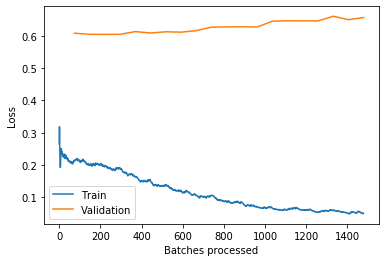

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.save('stage-2-112-rn50')

In [14]:
learn.export()

## Inference (for submission)

In [15]:
test_ds = ImageList.from_csv(path, 'test.csv', folder="Test Images")

In [16]:
# creating new learner to add test data
learn = load_learner(path, test=test_ds)

In [17]:
# prediction on testset
pred, y = learn.get_preds(ds_type=DatasetType.Test)

In [18]:
pred.shape

torch.Size([3219, 4])

In [19]:
pred[:3]

tensor([[1.7373e-02, 3.5806e-04, 9.7237e-01, 9.8983e-03],
        [1.1477e-03, 1.4636e-03, 9.9239e-01, 4.9960e-03],
        [3.7660e-05, 7.5307e-05, 8.9408e-01, 1.0581e-01]])

In [20]:
# extracting labels
labelled_pred = [ learn.data.classes[np.argmax(p)] for p in pred]

In [21]:
labelled_pred[:3]

['Food', 'Food', 'Food']

In [22]:
# filenames
fnames = [f.split('/')[-1] for f in learn.data.test_ds.items]

In [23]:
fnames[:3]

['image6245.jpg', 'image10409.jpg', 'image8692.jpg']

In [24]:
# reading test.csv order #to verify order
df = pd.read_csv(path/'test.csv')
df.head()

,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg


In [25]:
df = pd.DataFrame({'Image':fnames, "Class":labelled_pred}, columns=["Image", "Class"])

In [26]:
df.to_csv('submission_27.csv', index=False)

In [27]:
df = pd.read_csv('submission_27.csv')
df.head()

,Image,Class
0,image6245.jpg,Food
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire
